<a id=top-page></a>

# `pykitPIV` demo: Generate PyTorch ``Dataset`` with PIV image pairs

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#dataset">Construct a PyTorch Dataset object</a></li>
    <li><a href="#dataloader">Construct a PyTorch DataLoader object</a></li>

</ol>
<p></p>
</div>
<br>

***

In [18]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [3]:
image_size = (128,128)

In [4]:
size_buffer = 10

In [5]:
figsize = (5,3)

In [6]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=20,
                                             displacement=(0,10))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.7,0.8),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    image.remove_buffers()

    return image

<a id=synthetic-images-training-set></a>

### Create training set and validation set

[Go to the top](#top-page)

The training set will have 20 image pairs and the validation set will have 10 image pairs:

In [7]:
n_images = 30

We fix a random seed for generating the training set of PIV images:

In [8]:
training_random_seed = 100

In [9]:
images = generate_images(n_images, training_random_seed)

image_pairs = images.image_pairs_to_tensor()
image_targets = images.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


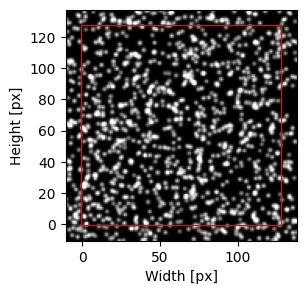

In [10]:
images.plot(0,
            instance=1,
            with_buffer=True,
            xlabel='Width [px]',
            ylabel='Height [px]',
            cmap='Greys_r',
            figsize=figsize);

In [11]:
tensors_dictionary = {"I"      : image_pairs, 
                      "targets": image_targets}

In [23]:
images.save_to_h5(tensors_dictionary,
                  save_individually=True,
                  filename='data/PyTorch-Dataset-PIV-pairs.h5', 
                  verbose=True)

data/PyTorch-Dataset-PIV-pairs-sample-0.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-1.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-2.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-3.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-4.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-5.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-6.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-7.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-8.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-9.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-10.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-11.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-12.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-13.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-14.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-15.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-16.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-17.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-18.h5	saved.
data/PyTorch-Dataset-PIV-pairs-sample-19.

<a id=dataset></a>

***

## Construct a PyTorch ``Dataset`` object

[Go to the top](#top-page)

Create IDs for each image pair:

In [28]:
class PIVDataset(Dataset):

  def __init__(self, image_IDs):
        self.image_IDs = image_IDs

  def __len__(self):
        return len(self.image_IDs)

  def __getitem__(self, index):

        ID = self.image_IDs[index]
      
        image = Image()
        sample_dictionary = image.upload_from_h5(filename='data/PyTorch-Dataset-PIV-pairs-' + ID + '.h5')

        X = sample_dictionary['I']
        y = sample_dictionary['targets']

        return X, y

In [29]:
PIV_data = PIVDataset(image_IDs=image_IDs)

In [30]:
len(PIV_data)

30

In [31]:
PIV_data[10]

(array([[[5.78154477e+03, 1.38406120e+03, 5.42566623e+03, ...,
          3.18643252e+03, 1.13823486e+03, 1.72772783e+03],
         [1.25981072e+04, 8.47992253e+03, 1.19277026e+04, ...,
          9.23138840e+03, 9.32603792e+03, 1.59223461e+04],
         [5.81861253e+04, 4.17092340e+04, 1.91048175e+04, ...,
          1.74448286e+04, 2.57995029e+04, 4.54907867e+04],
         ...,
         [2.80511602e+01, 3.28455098e+00, 4.03475636e+03, ...,
          2.93750074e+04, 1.99487275e+04, 2.75877162e+04],
         [4.67377070e+03, 1.69719229e+03, 1.48362996e+03, ...,
          1.92607705e+04, 3.07954669e+04, 4.71462278e+04],
         [2.74997509e+04, 9.98601947e+03, 1.15376933e+03, ...,
          8.58750844e+03, 2.69890589e+04, 4.30422555e+04]],
 
        [[1.56380432e+04, 2.69829261e+03, 3.14351613e+03, ...,
          7.00602291e+03, 1.20460120e+03, 1.33221948e+03],
         [1.31600125e+04, 3.87273497e+03, 5.27770221e+03, ...,
          1.56619247e+04, 7.22500903e+03, 1.12961775e+04],
       

<a id=dataloader></a>

***

## Construct a PyTorch ``DataLoader`` object

[Go to the top](#top-page)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

***